<a href="https://colab.research.google.com/github/YMGYM/google_colab_files/blob/master/ImageEmbedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
imgs = K.preprocessing.image.ImageDataGenerator()

In [ ]:
generator = imgs.flow_from_directory('/content/drive/MyDrive/Datasets/cafe_data', batch_size=2048)

Found 9466 images belonging to 3307 classes.


In [ ]:
x, y = generator.next()
x.shape

(2048, 256, 256, 3)

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
import os
import shutil
import time

def read_all_file(path):
    output = os.listdir(path)
    file_list = []
    
    for i in output:
        if os.path.isdir(path+'/' + i):
            file_list.extend(read_all_file(path+'/' + i))
        elif os.path.isfile(path+'/'+i):
            file_list.append(path+'/'+i)
    return file_list

def copy_all_file(file_list, new_path):
    for src_path in file_list:
        file = src_path.split('/')[-1]
        path = src_path.split('/')[-2]
        
        shutil.copyfile(src_path, new_path+'/'+path+'_'+file)

start_time = time.time()

src_path="/content/drive/MyDrive/Datasets/cafe_data"
new_path='img_merge'

file_list = read_all_file(src_path)
copy_all_file(file_list, new_path)

print('='*40)
print("러닝 타임: {}".format(time.time() - start_time))

KeyboardInterrupt: ignored

# TSNE + VGG16 을 활용한 임베딩 방법

https://github.com/pitripi/tsne-grid 을 수정하여 사용했습니다.

방법론은 https://towardsdatascience.com/developing-art-style-embeddings-for-visual-similarity-comparison-of-artworks-7a9d4ade2045 을 사용했습니다.

In [1]:
!unzip -q /content/drive/MyDrive/Datasets/cafe_images.zip  -d images/

In [2]:
!rm /content/images/img_merge/img_.DS_Store
!rm /content/images/img_merge/북스쿡스_2.jpg

In [3]:
!git clone https://github.com/pitripi/tsne-grid.git

Cloning into 'tsne-grid'...
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 187 (delta 2), reused 0 (delta 0), pack-reused 178
Receiving objects: 100% (187/187), 47.31 MiB | 43.92 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [3]:
!pip install lapjv==1.3.12

  Created wheel for lapjv: filename=lapjv-1.3.12-cp37-cp37m-linux_x86_64.whl size=117008 sha256=ccda89b4395e796762f625f9e95075b5c2acae9654329d3922adaa9bc52b3615
  Stored in directory: /root/.cache/pip/wheels/6e/b9/b2/73732c58540e65a9ce7939f435edd3ecca7b2f23532eaaee77
Successfully built lapjv


In [ ]:
!python3 tsne_grid.py --dir ./images/img_merge --size 10 --res 64 

2021-05-29 02:37:30.242650: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [4]:
import numpy as np
import os, argparse
import tensorflow as tf
import matplotlib as mlp
import matplotlib.pyplot as plt
from PIL import Image
from lapjv import lapjv
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist
from tensorflow.python.keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Flatten
from tensorflow.keras.preprocessing.image import img_to_array


out_res = 64
out_name = 'tsne_grid.jpg'
out_dim = 97
to_plot = np.square(out_dim)
perplexity = 50
tsne_iter = 5000
in_dir = './images/img_merge'
out_dir = './'


def load_img(in_dir):
    pred_img = [f for f in os.listdir(in_dir) if os.path.isfile(os.path.join(in_dir, f))]
    img_collection = []
    for idx, img in enumerate(pred_img):
        img = os.path.join(in_dir, img)
        print("image_load : ", idx + 1)
        img_collection.append(image.load_img(img, target_size=(out_res, out_res)))
    if (np.square(out_dim) > len(img_collection)):
        raise ValueError("Cannot fit {} images in {}x{} grid".format(len(img_collection), out_dim, out_dim))
    return img_collection

def get_activations(model, img_collection):
    activations = []
    for idx, img in enumerate(img_collection):
        if idx == to_plot:
            break;
        print("Processing image {}".format(idx+1))
        img = img.resize((224, 224), Image.ANTIALIAS)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        pred = model.predict(x)
        # pred = pred.reshape(49, 512)
        # gram = np.dot(pred, pred.T) # 그램 행렬로 변환
        # gram = gram.reshape(-1,)
        color_img = img_to_array(img.resize((5,5)))

        act = np.concatenate((pred.flatten(), color_img.flatten()))
        activations.append(act)
    return activations

def generate_tsne(activations):
    tsne = TSNE(perplexity=perplexity, n_components=2, init='random', n_iter=tsne_iter)
    X_2d = tsne.fit_transform(np.array(activations)[0:to_plot,:])
    X_2d -= X_2d.min(axis=0)
    X_2d /= X_2d.max(axis=0)
    return X_2d

def save_tsne_grid(img_collection, X_2d, out_res, out_dim):
    grid = np.dstack(np.meshgrid(np.linspace(0, 1, out_dim), np.linspace(0, 1, out_dim))).reshape(-1, 2)
    cost_matrix = cdist(grid, X_2d, "sqeuclidean").astype(np.float32)
    cost_matrix = cost_matrix * (100000 / cost_matrix.max())
    row_asses, col_asses, _ = lapjv(cost_matrix)
    grid_jv = grid[col_asses]
    out = np.ones((out_dim*out_res, out_dim*out_res, 3))

    for pos, img in zip(grid_jv, img_collection[0:to_plot]):
        h_range = int(np.floor(pos[0]* (out_dim - 1) * out_res))
        w_range = int(np.floor(pos[1]* (out_dim - 1) * out_res))
        out[h_range:h_range + out_res, w_range:w_range + out_res]  = image.img_to_array(img)

    im = image.array_to_img(out)
    im.save(out_dir + out_name, quality=100)

print("hello")
model = VGG16(weights='imagenet', include_top=False)
img_collection = load_img(in_dir)
activations = get_activations(model, img_collection)
print("Generating 2D representation.")
X_2d = generate_tsne(activations)
print("Generating image grid.")
save_tsne_grid(img_collection, X_2d, out_res, out_dim)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Processing image 4412
Processing image 4413
Processing image 4414
Processing image 4415
Processing image 4416
Processing image 4417
Processing image 4418
Processing image 4419
Processing image 4420
Processing image 4421
Processing image 4422
Processing image 4423
Processing image 4424
Processing image 4425
Processing image 4426
Processing image 4427
Processing image 4428
Processing image 4429
Processing image 4430
Processing image 4431
Processing image 4432
Processing image 4433
Processing image 4434
Processing image 4435
Processing image 4436
Processing image 4437
Processing image 4438
Processing image 4439
Processing image 4440
Processing image 4441
Processing image 4442
Processing image 4443
Processing image 4444
Processing image 4445
Processing image 4446
Processing image 4447
Processing image 4448
Processing image 4449
Processing image 4450
Processing image 4451
Processing image 4452
Processing image 4453
Processing image 4454
Processing image 4

우선 이미지 출력값을 그램 행렬로 변환 합니다.

In [ ]:
from tensorflow.python.keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Flatten

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False)
# top_model = Sequential()
# top_model.add(Flatten(input_shape=base_model.output_shape[1:]))

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.summary

<bound method Model.summary of <tensorflow.python.keras.engine.functional.Functional object at 0x7f517019d3d0>>

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

image = load_img('/content/images.jpeg')
input_arr = img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = base_model.predict(input_arr)

In [ ]:
x = predictions.reshape(49, 512)
xt = x.T

gram = np.dot(x, xt)

In [ ]:
gram.shape

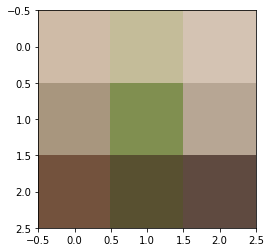

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(image.resize((3,3)))
plt.show()

In [ ]:
image.resize((10,10))

In [ ]:
resized_input = img_to_array(image.resize((5,5)))

In [ ]:
resized_input.flatten().shape

(75,)